In [1]:
import os
import glob
import pickle
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import LeavePGroupsOut
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as hc
import scipy.spatial.distance as dist
sns.set(rc={'figure.figsize':(8,4)}, font_scale=1)

In [2]:
def load_Y(sub, num_parcels, tasks, task2task_inv, firstlevel_dir, parc_label, space_label):
    
    Y_columns = ['task_name', 'task_index', 'session', 'contrast_id']
    for i in range(num_parcels):
        Y_columns.append('region_' + str(i))
    Y_rows = []
    count = 0
    for task_name_long in tasks:
        task_name_short = task2task_inv[task_name_long]
        task_idx = tasks.index(task_name_long)

        maps = sorted(glob.glob(f'{firstlevel_dir}/*/{sub}/parcellated/{parc_label}/{space_label}/{sub}_{task_name_short}_zmap.npy'))
        for m in maps:
            session = m.split('/')[-4]
            task_idx = tasks.index(task_name_long)

            Y_row = [task_name_long, task_idx, session, count]
            Y_row.extend(list(np.load(m)[0]))
            Y_rows.append(Y_row)

    Y = pd.DataFrame(Y_rows, columns=Y_columns)
    
    return Y



def calculate_metrics(Y_TEST, Y_PRED, test_groups):
    '''
    Calculates 2-way classification accuracy, along with correlation and r-squared for each test item.
    '''
    # Because there are unequal groups (e.g., a held-out task can have 2 or 4 instances), convert these group indices into a binary array
    task_0_indices = np.argwhere(test_groups == np.min(test_groups)).flatten()
    task_1_indices = np.argwhere(test_groups == np.max(test_groups)).flatten()

    # Separate out the true maps for the two tasks
    tests_0 = Y_TEST[task_0_indices]
    tests_1 = Y_TEST[task_1_indices]

    # There will be 2 unique predictions per split, one for each held-out task
    pred_0 = Y_PRED[task_0_indices[0]]
    pred_1 = Y_PRED[task_1_indices[0]]

    # Calculate the 2-way correlations
    corrs_pred0_test0 = np.corrcoef(pred_0, tests_0)[0,1:]
    corrs_pred0_test1 = np.corrcoef(pred_0, tests_1)[0,1:]
    corrs_pred1_test1 = np.corrcoef(pred_1, tests_1)[0,1:]
    corrs_pred1_test0 = np.corrcoef(pred_1, tests_0)[0,1:]
    
    # Aggregate correlation lists (of variable length) 
    corr_vals = [corrs_pred0_test0, corrs_pred1_test1] 
    
    # Calculate 2-way classification accuracy (based on average correlations)
    acc_0, acc_1, accuracy = 0, 0, 0
    if np.mean(corrs_pred0_test0) > np.mean(corrs_pred0_test1):
        acc_0 = 1
    if np.mean(corrs_pred1_test1) > np.mean(corrs_pred1_test0):
        acc_1 = 1
    if acc_0 and acc_1:
        accuracy = 1
    accuracy_tuple = (acc_0, acc_1)
    
    # Calculate r-squared list (of variable length) for each task
    r2_pred0_test0 = np.array([r2_score(true.T, pred_0.T) for true in tests_0])
    r2_pred1_test1 = np.array([r2_score(true.T, pred_1.T) for true in tests_1])
    r2_vals = [r2_pred0_test0, r2_pred1_test1]
    
    return accuracy, accuracy_tuple, corr_vals, r2_vals



def generalize(param_df, X_df, X_mat, subs, num_parcels, task2task_inv, firstlevel_dir, parc_label, space_label):

    N = len(subs)
    res_mat_acc1 = np.zeros([N, N])
    res_mat_acc2 = np.zeros([N, N])
    res_mat_corr = np.zeros([N, N])
    res_mat_r2   = np.zeros([N, N])
    
    for train_sub in subs:
        print('Generalizing from:', train_sub)
        sub_betas = param_df[param_df['sub']==train_sub]['coefs'].values[0]
        sub_intercepts = param_df[param_df['sub']==train_sub]['intercepts'].values[0]
        Y_preds = np.dot(X_mat, sub_betas.T) + sub_intercepts.T

        for test_sub in subs:
            Y_df = load_Y(test_sub, num_parcels, tasks, task2task_inv, firstlevel_dir, parc_label, space_label)
            Y_trues = Y_df.filter(regex='region').values

            acc_1, acc_2, count = 0, 0, 0
            corrs_list = []
            r2_list = []
            
            splitter_outerLoop = LeavePGroupsOut(n_groups=2)
            groups = np.array(X_df.task_index)

            for train_idx, test_idx in splitter_outerLoop.split(X_df, Y_df, groups=groups):
                count += 1

                # Measure model performance
                test_groups = groups[test_idx]
                Y_PRED = Y_preds[test_idx]
                Y_TEST = Y_trues[test_idx]                
                acc1, acc2, corr_vals, r2_vals = calculate_metrics(Y_TEST, Y_PRED, test_groups)
                for c in corr_vals:
                    corrs_list.extend(c)
                for r2 in r2_vals:
                    r2_list.extend(r2)

                acc_1 += acc1
                acc_2 += sum(acc2)

            train_sub_idx = subs.index(train_sub)
            test_sub_idx  = subs.index(test_sub)
            
            res_mat_acc1[train_sub_idx, test_sub_idx] = acc_1/count
            res_mat_acc2[train_sub_idx, test_sub_idx] = acc_2/(count*2)
            res_mat_corr[train_sub_idx, test_sub_idx] = np.mean(corrs_list)
            res_mat_r2[train_sub_idx, test_sub_idx]   = np.mean(r2_list)
        
    return res_mat_acc1, res_mat_acc2, res_mat_corr, res_mat_r2

In [3]:
## Define params
firstlevel_label = 'first_level_bySession'
analysis_name = 'analysis-3_savedCoefs'
feature_set = 'all'
num_parcels = 1000
model_name = 'RidgeCV'
parc_label = 'schaefer_2018'
space_label = 'MNI152NLin2009cAsym'


## Define paths
proj_dir = os.path.abspath(os.path.join(os.getcwd(), '../..'))
output_dir = os.path.join(proj_dir, 'model_outputs')
resources_dir = os.path.join(proj_dir, 'resources')
firstlevel_dir = os.path.join(proj_dir, 'Y_data', firstlevel_label)
results_dir = os.path.join(output_dir, firstlevel_label, analysis_name, model_name)
features_dir = os.path.join(proj_dir, 'X_features')


## Load task2task dict (for more readable naming format), and get task order
with open(os.path.join(resources_dir, 'dicts/task2task.json'), 'rb') as f:
    task2task = json.load(f)
task2task_inv = {v: k for k, v in task2task.items()}


## Load X
X_byTask_dir = os.path.join(features_dir, 'byTask', 'X_all.csv')
X_byTask = pd.read_csv(X_byTask_dir, index_col=0)
features = X_byTask.columns.tolist()
tasks = X_byTask.index.tolist()

X_byTaskbySession_dir = os.path.join(features_dir, 'byTask_bySession', 'X_all.csv')
X_byTaskbySession = pd.read_csv(X_byTaskbySession_dir, index_col=0)

X_mat = X_byTaskbySession.filter(features)


## Load model parameters 

# Get list of pkl files
dict_list = []
res_files = sorted(glob.glob(os.path.join(results_dir, '*')))
for f in res_files:
    with open(f, 'rb') as f:
        dict_list.append(pickle.load(f)) 

# Aggregate into df
cols = ['parcels', 'feature_set', 'model_name', 'sub', 'coefs', 'intercepts']
param_df = pd.DataFrame(columns=cols)

for d in dict_list:
    num_parcels = list(d.keys())[0]
    feature_set = list(d[num_parcels].keys())[0]
    model_name = list(d[num_parcels][feature_set].keys())[0]
    sub = list(d[num_parcels][feature_set][model_name].keys())[0]
    metrics = list(d[num_parcels][feature_set][model_name][sub].keys())
    sub_res = d[num_parcels][feature_set][model_name][sub]
    
    row = [num_parcels, feature_set, model_name, sub, sub_res['coefs'][0], sub_res['intercepts'][0]]
    param_df = param_df.append(pd.Series(row, index=cols), ignore_index=True)
    

# Define subs
subs = param_df['sub'].unique().tolist()

In [4]:
run = False
if run:
    results = generalize(param_df, X_byTaskbySession, X_mat, subs,
                         num_parcels, task2task_inv, firstlevel_dir,
                         parc_label, space_label)
    acc1_mat, acc2_mat, corr_mat, r2_mat = results

In [5]:
## Save results
save = False
if save:
    with open('transfer_acc1.csv', 'wb') as f:
        pickle.dump(pd.DataFrame(acc1_mat, index=subs, columns=subs), f)
    with open('transfer_acc2.csv', 'wb') as f:
        pickle.dump(pd.DataFrame(acc2_mat, index=subs, columns=subs), f)
    with open('transfer_corr.csv', 'wb') as f:
        pickle.dump(pd.DataFrame(corr_mat, index=subs, columns=subs), f)
    with open('transfer_r2.csv', 'wb') as f:
        pickle.dump(pd.DataFrame(r2_mat, index=subs, columns=subs), f)
        
## Load results
load = True
if load:
    with open('transfer_acc1.csv', 'rb') as f:
        acc1_mat = pickle.load(f).values
    with open('transfer_acc2.csv', 'rb') as f:
        acc2_mat = pickle.load(f).values
    with open('transfer_corr.csv', 'rb') as f:
        corr_mat = pickle.load(f).values
    with open('transfer_r2.csv', 'rb') as f:
        r2_mat = pickle.load(f).values

In [6]:
def plot_bySubject(res_mat, metric, title, subs):
    res_df = pd.DataFrame(res_mat, columns=[f'{s}' for s in subs])
    res_df['source'] =[f'{s}' for s in subs]
    res_df = res_df.melt(var_name='target', value_name=metric, id_vars=['source'])
    order = [subs[i] for i in np.argsort(res_mat.diagonal())]

    sns.set(style='white', font_scale=3)
    plt.figure(figsize=(30,10))
    plt.tight_layout()

    ax = sns.stripplot(x='source', y=metric, data=res_df, order=order,
                       color='grey', edgecolor='grey', s=5, alpha=0.75)

    sns.scatterplot(x=order, y=res_mat.diagonal()[np.argsort(res_mat.diagonal())],
                    color='green', s=500, alpha=0.75)
        
    ax.set_ylim(0,1)
    ax.set_xlabel('Source Subject')
    ax.set_ylabel(f'{title}\non target subjects')
    ax.set_xticklabels(order, rotation=45);
    
    #plt.savefig(os.path.join(figdir, 'subject-transfer_accuracy-violins.%s' % filetype))

In [15]:
metric = 'corr'
res_df = pd.DataFrame(corr_mat, columns=[f'{s}' for s in subs])
res_df['source'] =[f'{s}' for s in subs]
res_df = res_df.melt(var_name='target', value_name=metric, id_vars=['source'])

transfer_others = res_df[res_df['source']!=res_df['target']].groupby('source').mean()
transfer_others

,corr
source,
sub-02,0.337360
sub-03,0.365645
sub-04,0.399033
sub-06,0.380303
sub-08,0.369800
sub-09,0.368723
sub-10,0.415578
sub-12,0.369631
sub-14,0.352493


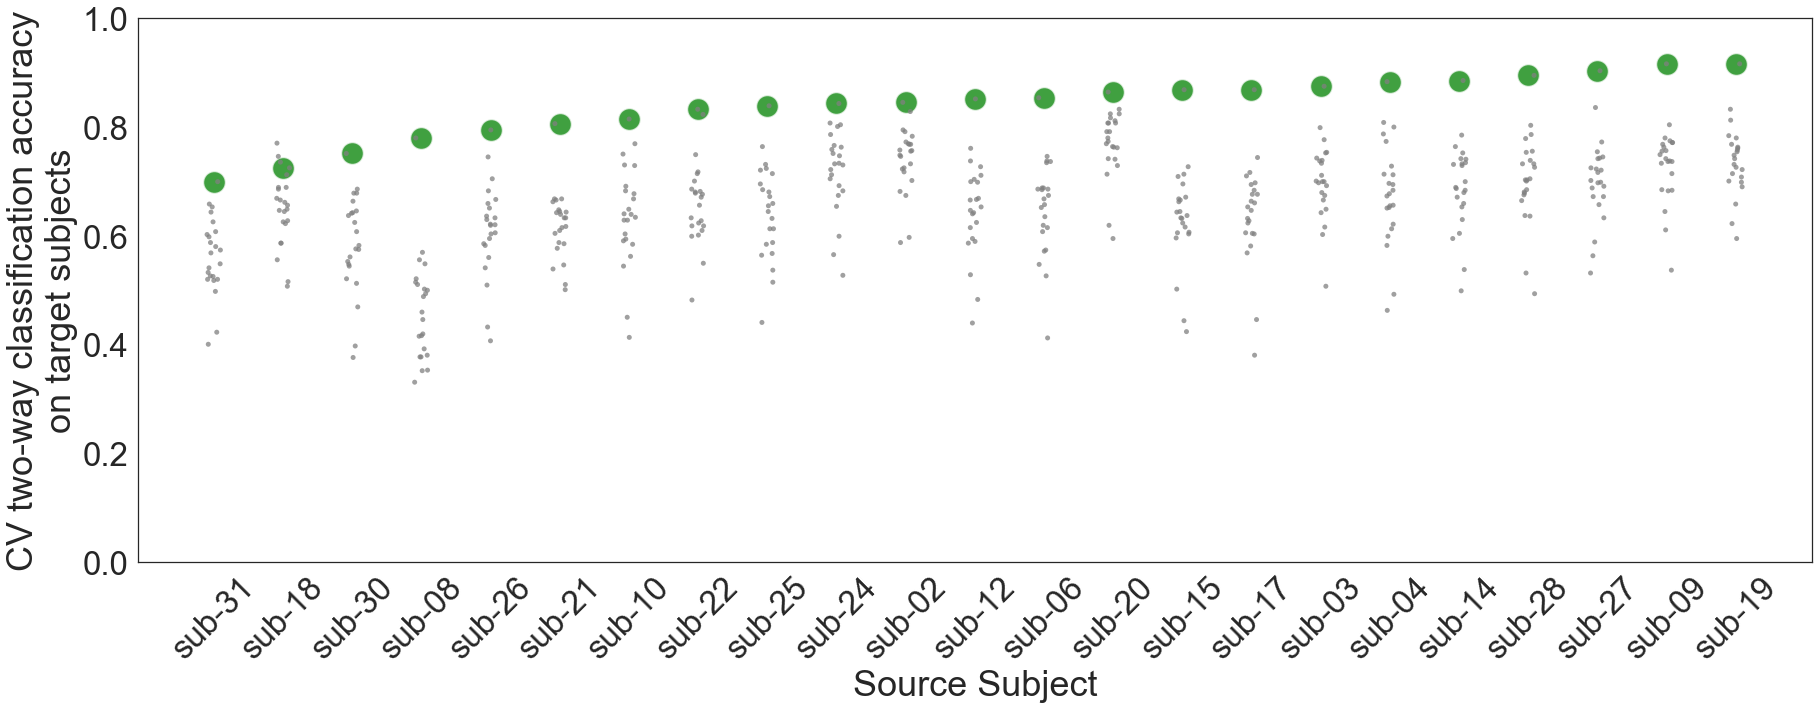

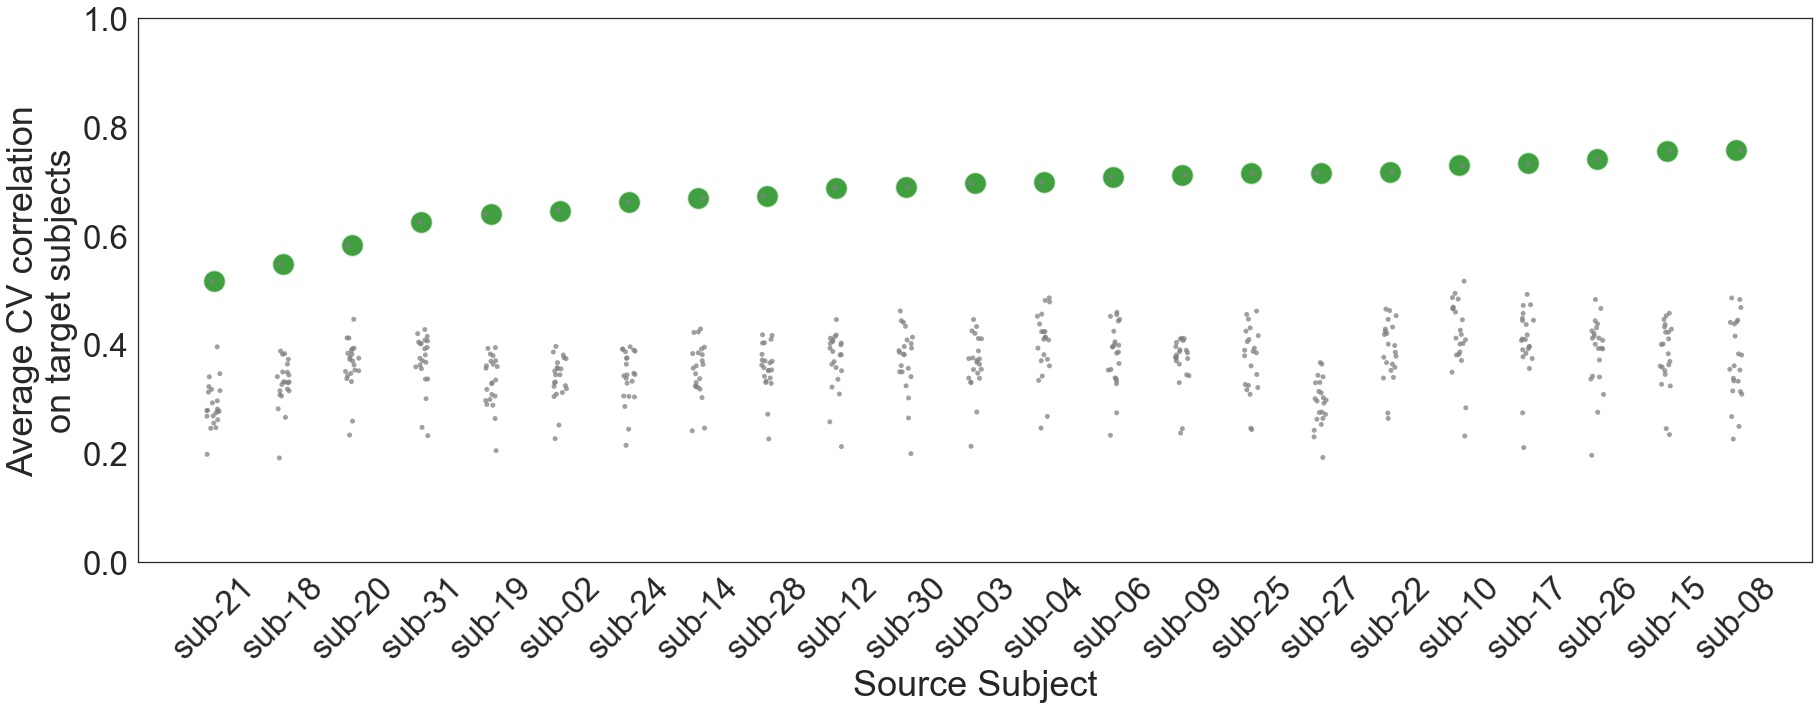

In [7]:
plot_bySubject(res_mat=acc1_mat, metric='acc1', title='CV two-way classification accuracy', subs=subs)
plot_bySubject(res_mat=corr_mat, metric='avg_corr', title='Average CV correlation', subs=subs)

In [8]:
def report_metric(res_mat, metric, subs):
    print('*' * 40)
    print(f'Metric: {metric}')
    res_df = pd.DataFrame(res_mat, columns=[f'{s}' for s in subs])
    res_df['source'] =[f'{s}' for s in subs]
    res_df = res_df.melt(var_name='target', value_name=metric, id_vars=['source'])

    transfer_others = res_df[res_df['source']!=res_df['target']].groupby('source').mean()
    transfer_self = res_df[res_df['source']==res_df['target']].groupby('source').mean()

    print('\nTransfer to others')
    res = transfer_others[metric]
    print(f'M = {res.mean():0.2f}, SD = {res.std():0.2f}')
    print(f'Min: {res.min():0.2f}, Max: {res.max():0.2f}')

    print('\nTransfer to self')
    res = transfer_self[metric]
    print(f'M = {res.mean():0.2f}, SD = {res.std():0.2f}')
    print(f'Min: {res.min():0.2f}, Max: {res.max():0.2f}')
    
    print('*' * 40); print()
    

report_metric(acc1_mat, 'acc1', subs)
report_metric(corr_mat, 'corr', subs)

****************************************
Metric: acc1

Transfer to others
M = 0.65, SD = 0.07
Min: 0.45, Max: 0.77

Transfer to self
M = 0.84, SD = 0.06
Min: 0.70, Max: 0.92
****************************************

****************************************
Metric: corr

Transfer to others
M = 0.36, SD = 0.03
Min: 0.29, Max: 0.42

Transfer to self
M = 0.68, SD = 0.06
Min: 0.52, Max: 0.76
****************************************



In [9]:
def plot_mats(res_mat, subs, similarity='correlation', method='average'):
    sns.set(style='white', font_scale=3)
    
    filetype = 'pdf'
    figdir = 'figures/subject-transfer'
    if not os.path.exists(figdir):
        os.makedirs(figdir)
    
    res_df = pd.DataFrame(res_mat, index=subs, columns=subs)
    
    plt.figure(figsize=(20,20))
    ax = sns.heatmap(res_df, yticklabels=True, xticklabels=True,
                     linewidths=0.05, linecolor='gray', cbar=None)
    plt.tight_layout()
    plt.xlabel('Target', fontsize=60)
    plt.ylabel('Source', fontsize=60)
    #plt.savefig(os.path.join(figdir, 'subject-transfer_accuracy-matrix.%s' % filetype))    
    
    plt.figure(figsize=(20,20))
    ax = sns.heatmap(res_df, yticklabels=True, xticklabels=True,
                     linewidths=0.05, linecolor='gray')
    ax.set(ylabel='Source', xlabel='Target')
    plt.tight_layout()
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=100)
    
        
    sub_sim = dist.pdist(res_mat, metric=similarity)
    sub_rdm = dist.squareform(sub_sim)
    sub_rdm_df = pd.DataFrame(sub_rdm, index=subs, columns=subs)
    linkage = hc.linkage(sub_sim, method=method)
    
    plt.figure()
    ax = sns.clustermap(sub_rdm_df, row_linkage=linkage, col_linkage=linkage,
                        yticklabels=True, xticklabels=True, cbar_pos=None,
                        linewidths=0.05, linecolor='gray',
                        vmin=0, vmax=0.75, figsize=(20,20))
    plt.tight_layout()
    #plt.savefig(os.path.join(figdir, 'subject-transfer_clustering.%s' % filetype))

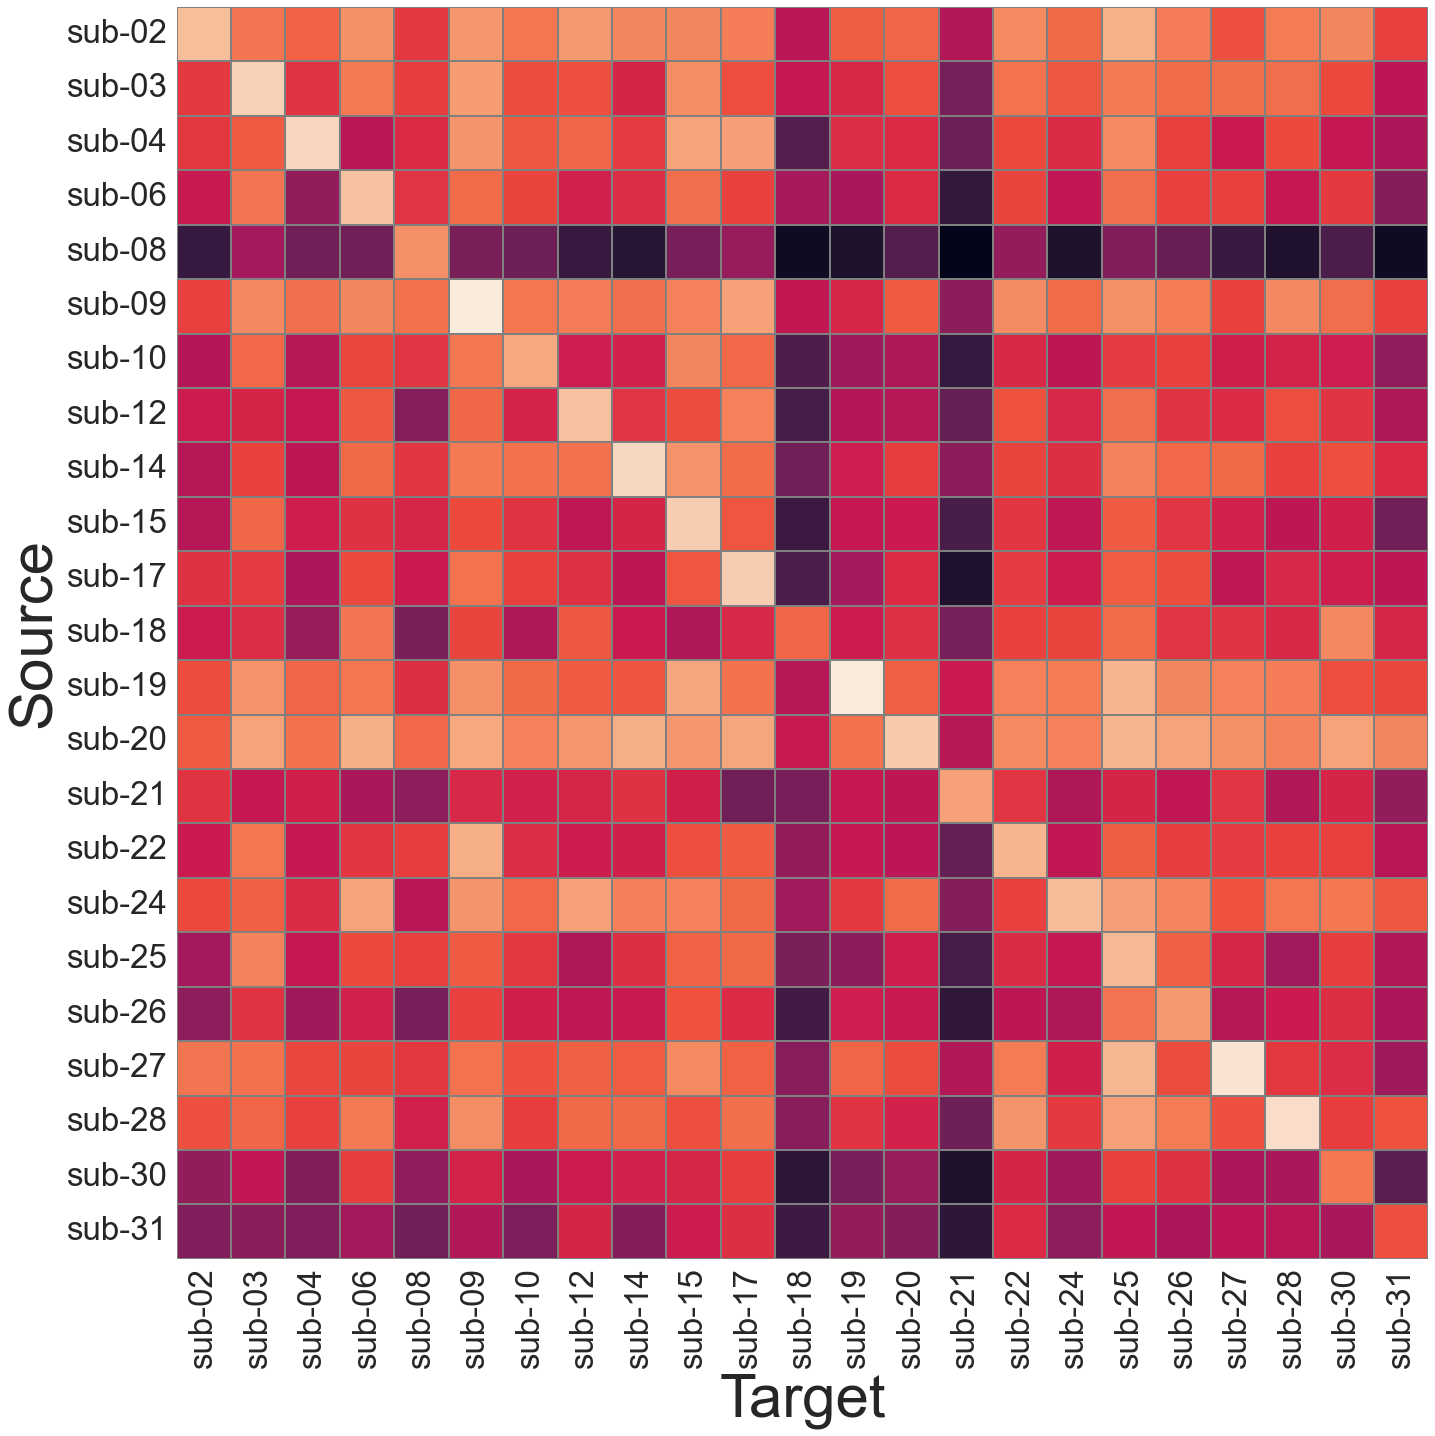

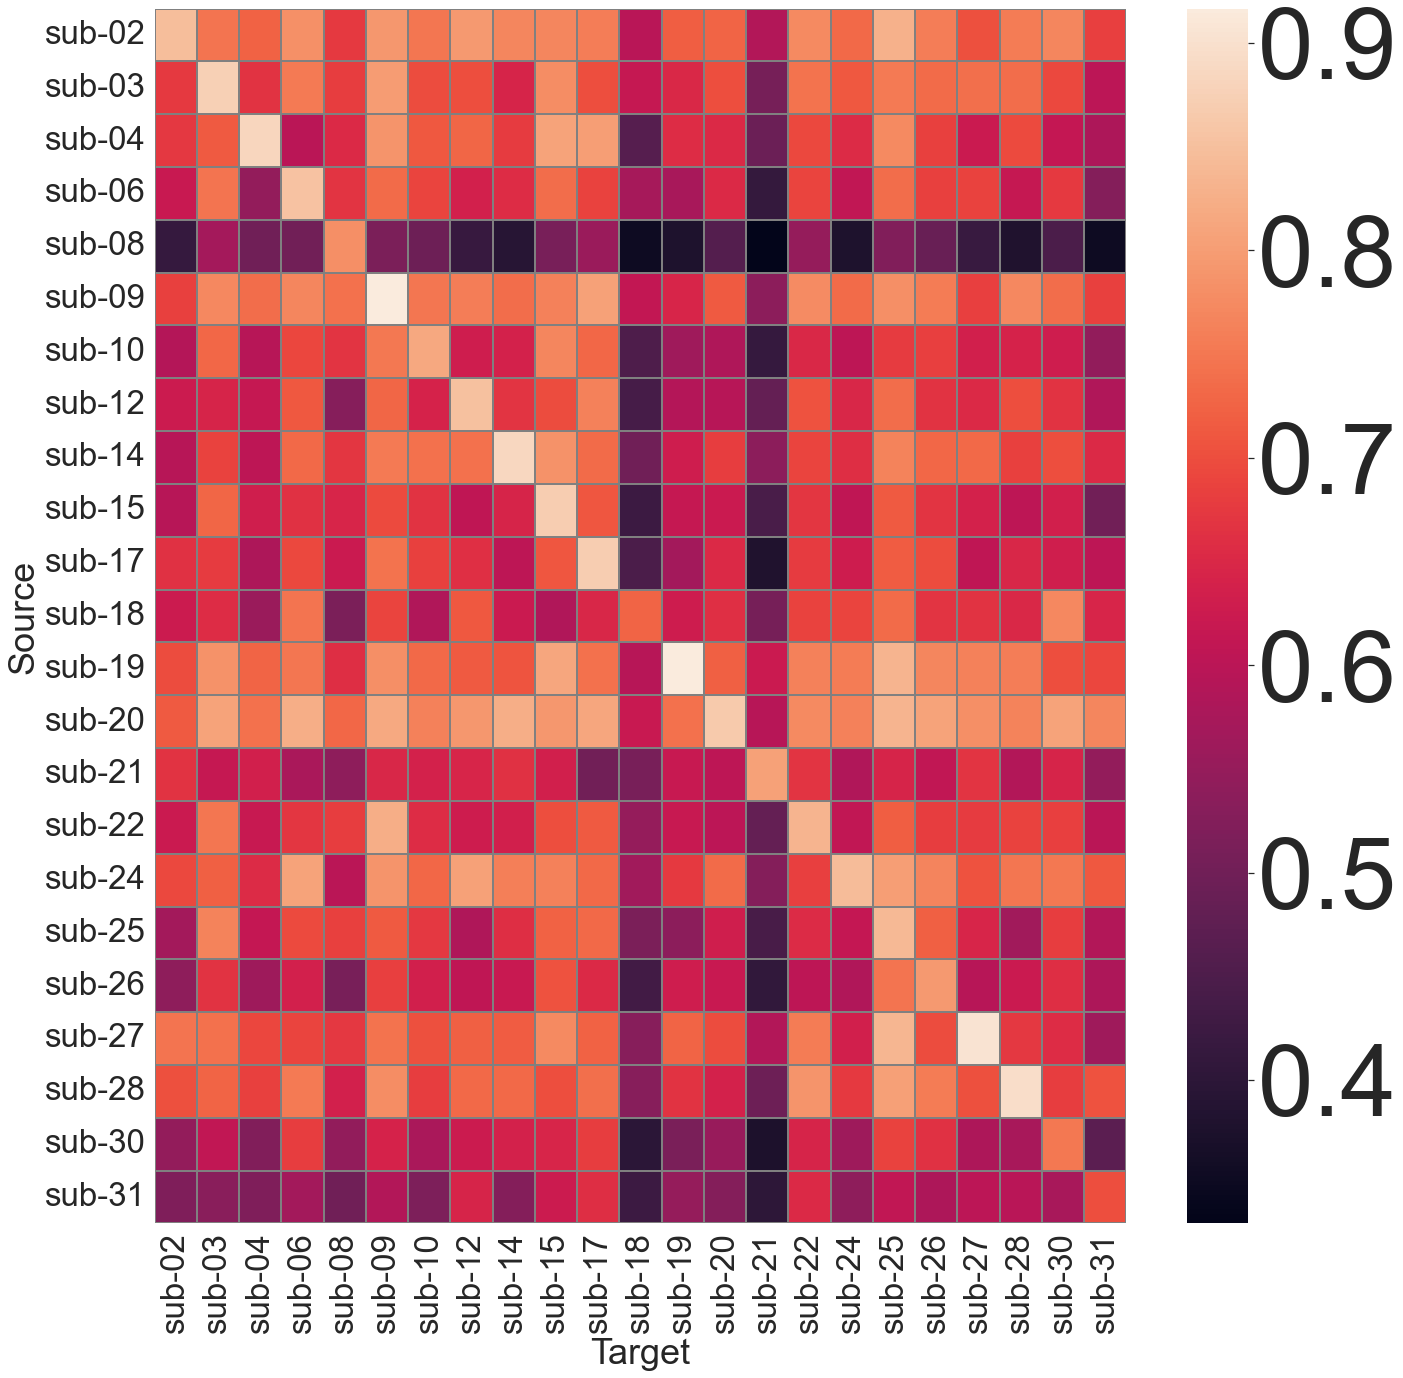

<Figure size 576x288 with 0 Axes>

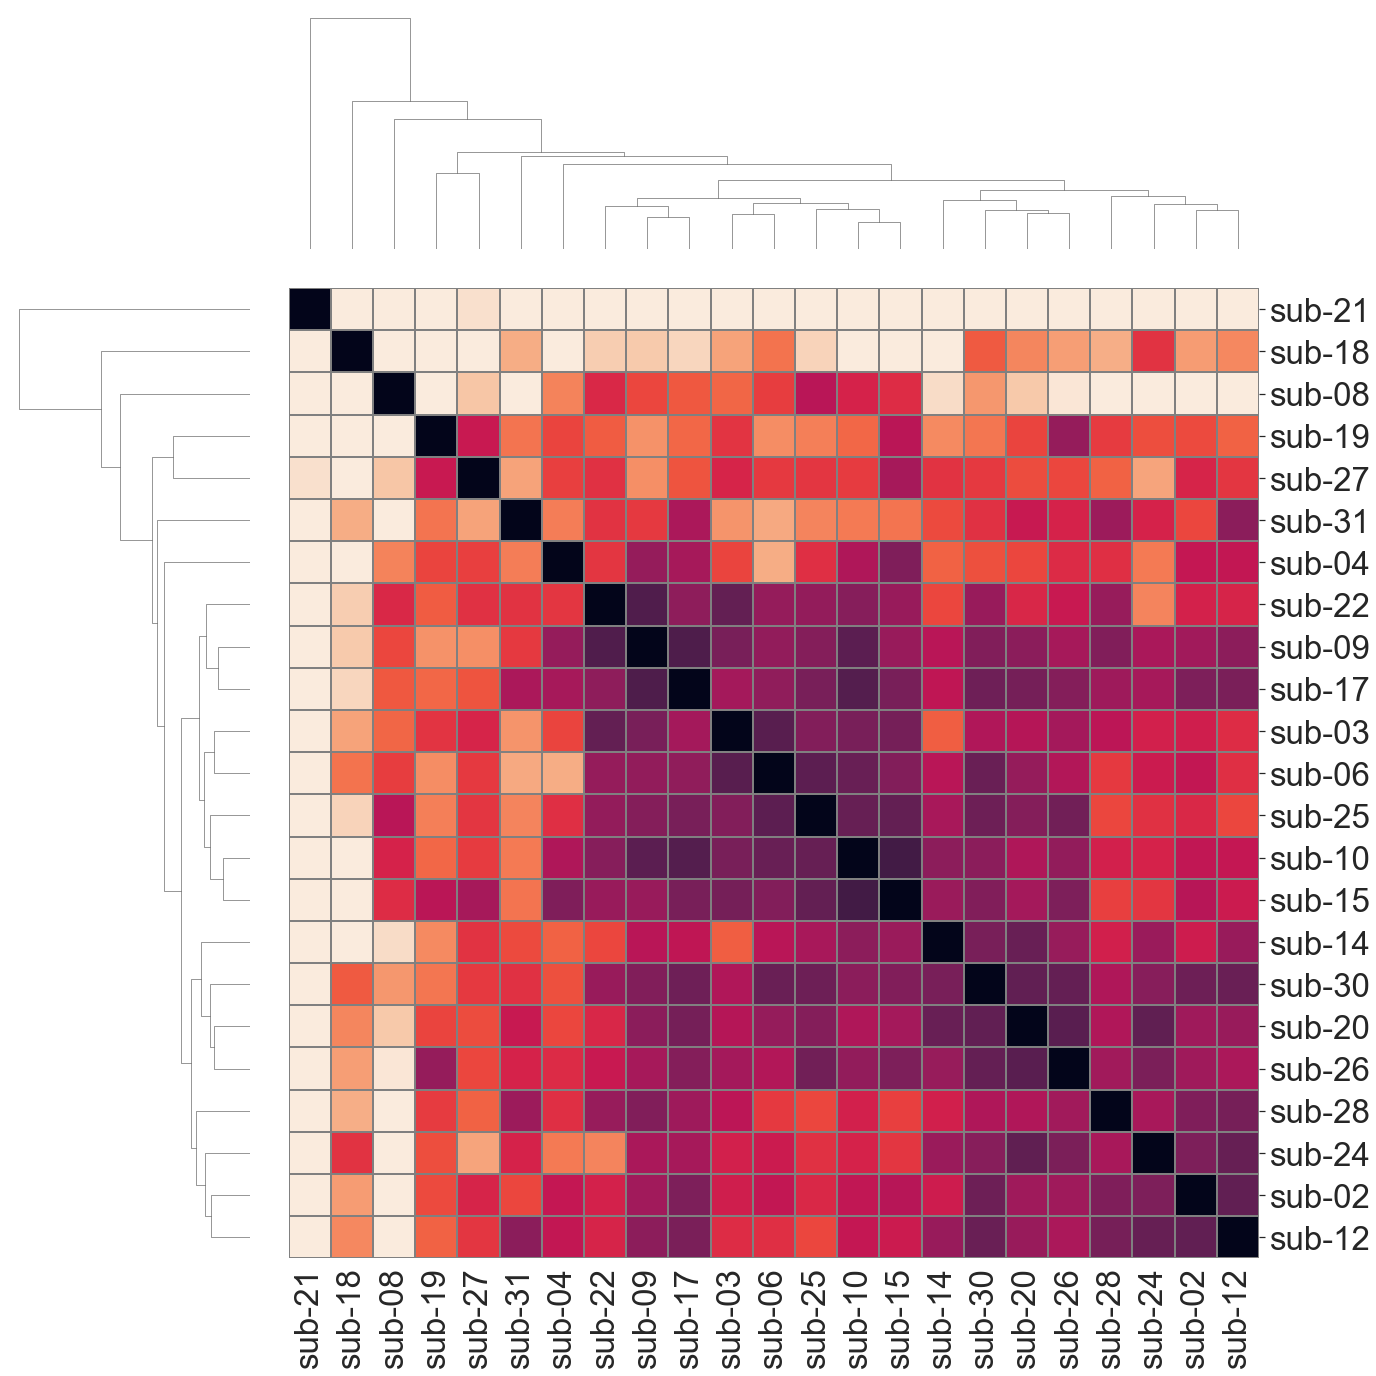

In [10]:
plot_mats(acc1_mat, subs, similarity='correlation', method='average');